# Face Mask Detection
 (Dataset from https://www.kaggle.com/datasets/shiekhburhan/face-mask-dataset?resource=download)

In [1]:
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow import keras
from tensorflow.keras import layers, models, Model

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Grab Data

Data is stored in Google Drive. We will use a 80/20 split for model evaluation, with no validation set for tuning parameters.. just a single and final evaluation at the end of training. 

In [17]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'gdrive/My Drive/face_mask',
    labels='inferred',
    color_mode='grayscale',
    label_mode = 'categorical',
    image_size=(256, 256),
    shuffle=True,
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

test_data = tf.keras.utils.image_dataset_from_directory(
    'gdrive/My Drive/face_mask',
    labels='inferred',
    color_mode='grayscale',
    label_mode = 'categorical',
    image_size=(256, 256),
    shuffle=True,
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 14536 files belonging to 3 classes.
Using 11629 files for training.
Found 14536 files belonging to 3 classes.
Using 2907 files for validation.


In [3]:
print(train_data.class_names)
print(test_data.class_names)

['incorrect_mask', 'with_mask', 'without_mask']
['incorrect_mask', 'with_mask', 'without_mask']


In [4]:
train_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

Augmentation to help generalization!

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomRotation(0.35),
        layers.RandomZoom((-0.1, 0.03))
    ]
)

# Create Model

In [21]:
model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(3, activation='softmax'))

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy', 'Precision', 'Recall'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)


history = model.fit(
  train_data,
  epochs=200,
  callbacks=[callback]
)

Epoch 1/200
364/364 [==============================] - 20s 49ms/step - loss: 0.5791 - accuracy: 0.7593 - precision: 0.7850 - recall: 0.7253
Epoch 2/200
364/364 [==============================] - 18s 48ms/step - loss: 0.3308 - accuracy: 0.8711 - precision: 0.8810 - recall: 0.8575
Epoch 3/200
364/364 [==============================] - 18s 48ms/step - loss: 0.2786 - accuracy: 0.8949 - precision: 0.9022 - recall: 0.8872
Epoch 4/200
364/364 [==============================] - 18s 48ms/step - loss: 0.2600 - accuracy: 0.8981 - precision: 0.9068 - recall: 0.8904
Epoch 5/200
364/364 [==============================] - 18s 48ms/step - loss: 0.2484 - accuracy: 0.9033 - precision: 0.9098 - recall: 0.8952
Epoch 6/200
364/364 [==============================] - 18s 49ms/step - loss: 0.2278 - accuracy: 0.9115 - precision: 0.9191 - recall: 0.9037
Epoch 7/200
364/364 [==============================] - 18s 48ms/step - loss: 0.2061 - accuracy: 0.9195 - precision: 0.9257 - recall: 0.9132
Epoch 8/200
364/364 

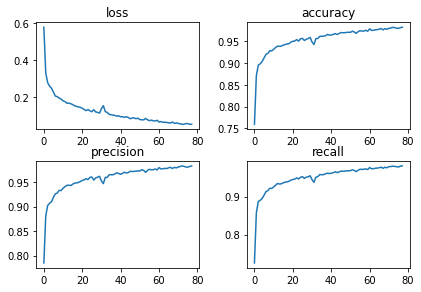

In [67]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2)
fig.tight_layout()
ax[0,0].plot(history.history['loss'])
ax[0,0].title.set_text('loss')
ax[0,1].plot(history.history['accuracy'])
ax[0,1].title.set_text('accuracy')
ax[1,0].plot(history.history['precision'])
ax[1,0].title.set_text('precision')
ax[1,1].plot(history.history['recall'])
ax[1,1].title.set_text('recall')

# Evaluate model!

We will make predictions on our test set which we got earlier. The output will be loss, accuracy, precision, and recall

In [22]:
model.evaluate(test_data)

91/91 [==============================] - 2s 16ms/step - loss: 0.2197 - accuracy: 0.9398 - precision: 0.9424 - recall: 0.9391


[0.21973535418510437, 0.939800500869751, 0.942354142665863, 0.9391124844551086]

In [54]:
test_label = np.concatenate([y for x, y in test_data], axis=0)
predict=model.predict(test_data) 
predicted_classes=np.argmax(predict,axis=1)
print(classification_report(np.argmax(test_label, axis=1), predicted_classes, target_names=['incorrect_mask', 'with_mask', 'without_mask']))

                precision    recall  f1-score   support

incorrect_mask       0.98      0.95      0.97      1012
     with_mask       0.90      0.95      0.93       942
  without_mask       0.93      0.92      0.93       953

      accuracy                           0.94      2907
     macro avg       0.94      0.94      0.94      2907
  weighted avg       0.94      0.94      0.94      2907



# Feature Maps

We will use an image I randomly selected to visualize the feature maps

In [55]:
model.layers

## An example of feature maps using a complex image from the with_mask class

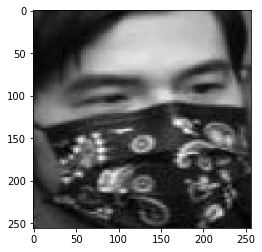

In [97]:
image = load_img('gdrive/MyDrive/face_mask/with_mask/complex1.jpg' , color_mode='grayscale', target_size=(256,256))
plt.imshow(image, cmap='gray')
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

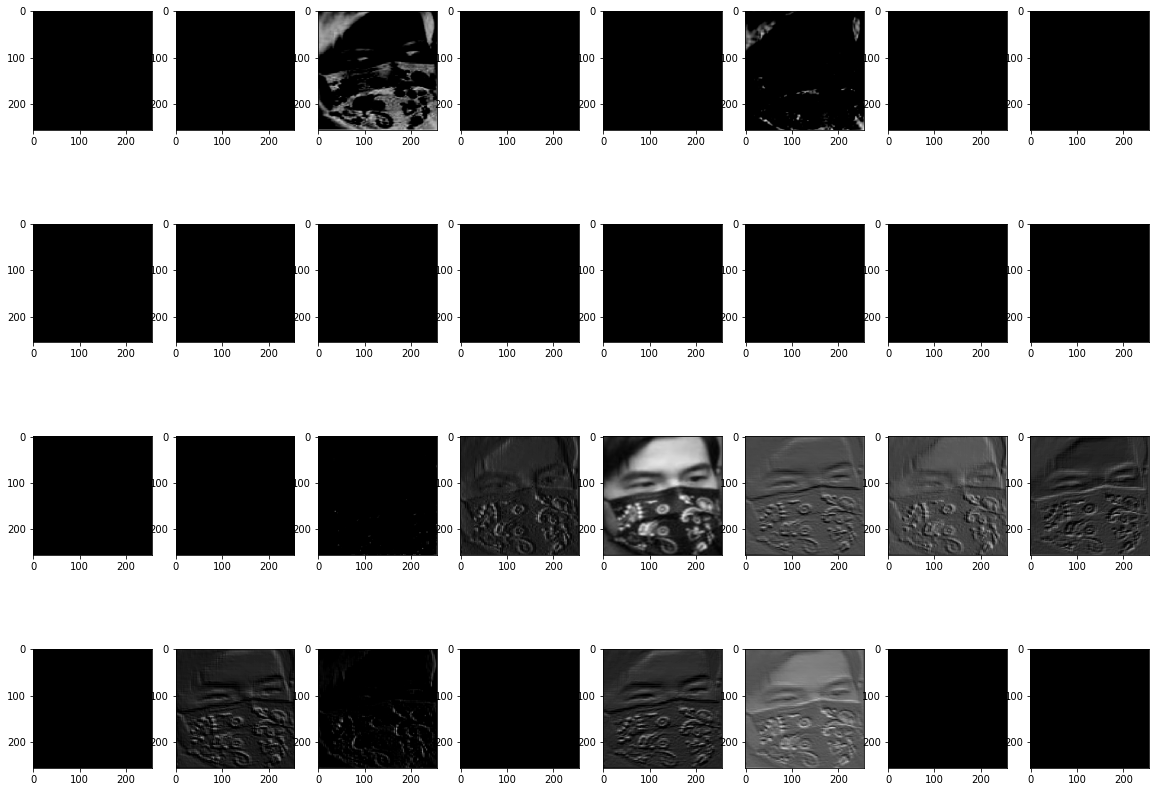

In [101]:
temp_model = Model(inputs=model.inputs , outputs=model.layers[2].output)
features = temp_model.predict(image)

fig = plt.figure(figsize=(20,15))
fig.tight_layout()
for i in range(features.shape[3]):

    plt.subplot(4,8,i+1)
    plt.imshow(features[0,:,:,i] , cmap='gray')
    
plt.show()

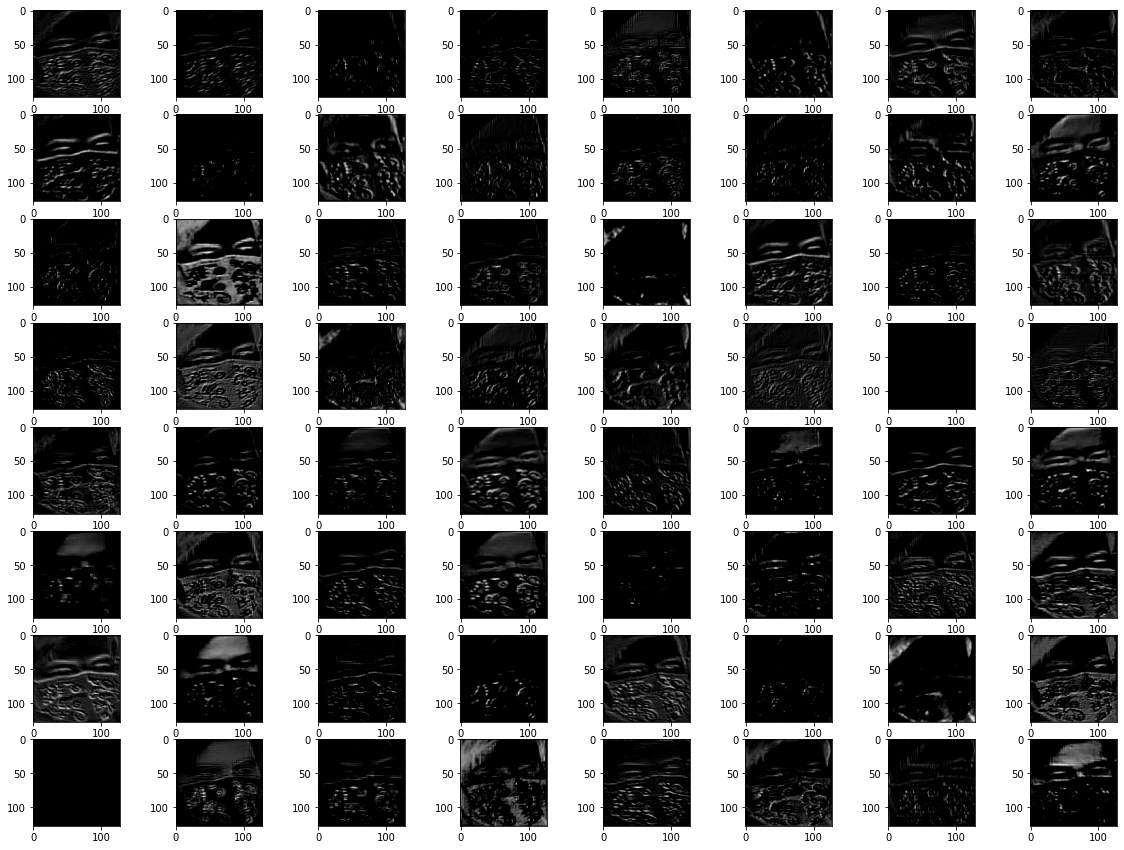

In [100]:
temp_model = Model(inputs=model.inputs , outputs=model.layers[5].output)

features = temp_model.predict(image)

fig = plt.figure(figsize=(20,15))
fig.tight_layout()
for i in range(features.shape[3]):

    plt.subplot(8,8,i+1)
    plt.imshow(features[0,:,:,i] , cmap='gray')
    
plt.show()

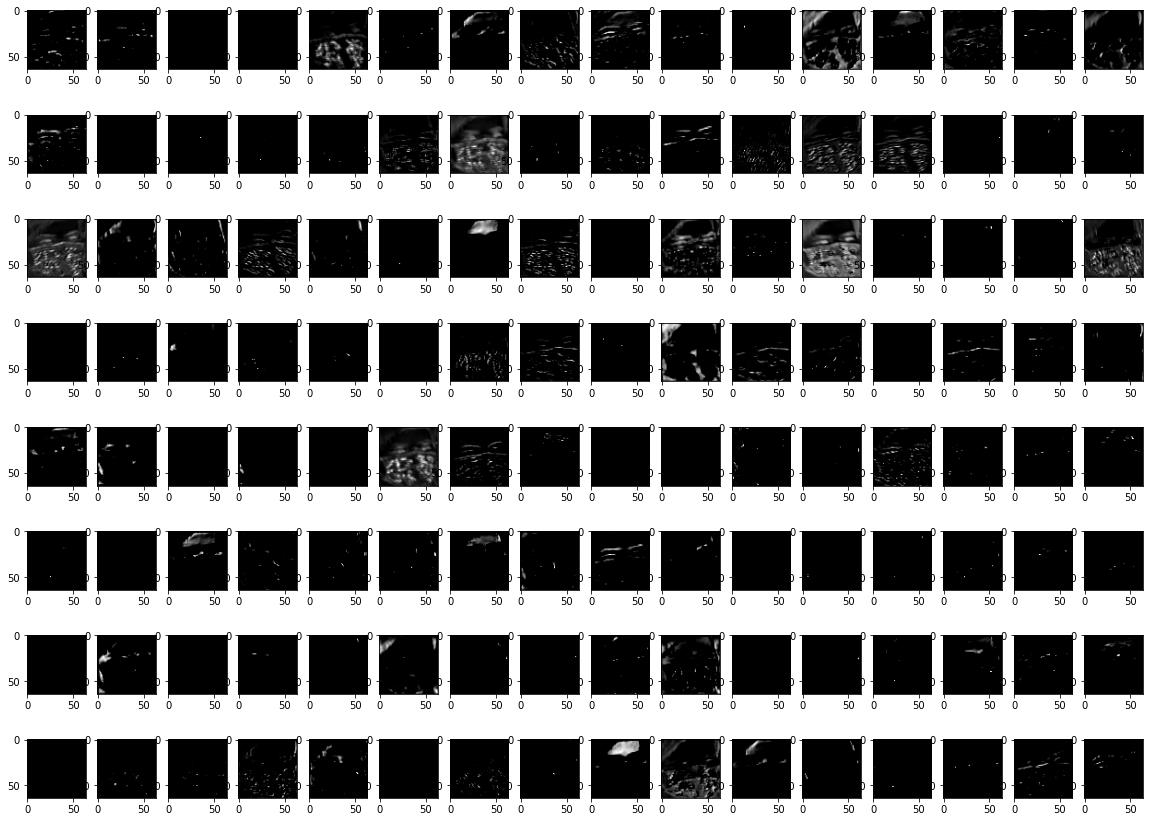

In [85]:
temp_model = Model(inputs=model.inputs , outputs=model.layers[8].output)

features = temp_model.predict(image)

fig = plt.figure(figsize=(20,15))
fig=plt.tight_layout()
for i in range(features.shape[3]):

    plt.subplot(8,16,i+1)
    plt.imshow(features[0,:,:,i] , cmap='gray')
    
plt.show()

# Evaluating the model on pictures of myself!

I thought this would be a fun way to see how effective the model is given photos of myself (not included in training or test sets)

## Without Mask

Class = 2

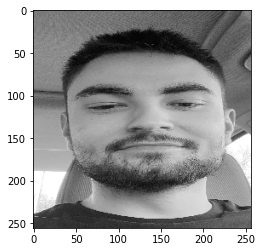

In [42]:
image = load_img('unnamed-4.jpg' , color_mode='grayscale', target_size=(256,256))
plt.imshow(image, cmap='gray')
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

In [43]:
np.argmax(model.predict(image)) # woohoo without mask predicted properly!

2

In [44]:
model.predict(image)

array([[4.8257811e-05, 1.1389924e-05, 9.9994040e-01]], dtype=float32)

## With Mask

Class = 1

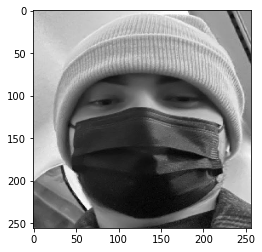

In [51]:
image = load_img('unnamed-3.jpg' , color_mode='grayscale', target_size=(256,256))
plt.imshow(image, cmap='gray')
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

In [52]:
np.argmax(model.predict(image)) # woohoo with mask predicted properly!

1

In [53]:
model.predict(image)
# interesting, incorrect mask not too far.. I wonder if hat plays a role?

array([[0.44369483, 0.54653656, 0.00976866]], dtype=float32)

## Incorrect Mask

Class = 0

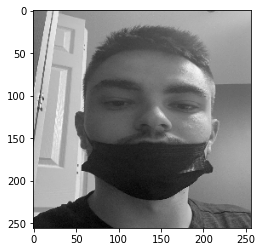

In [39]:
image = load_img('unnamed-7.jpg' , color_mode='grayscale', target_size=(256,256))
plt.imshow(image, cmap='gray')
# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = np.expand_dims(image, axis=0)

In [40]:
np.argmax(model.predict(image))  # woohoo without mask predicted properly!

0

In [41]:
model.predict(image)

array([[9.9998951e-01, 1.2801871e-08, 1.0490602e-05]], dtype=float32)

# Conclusion

The model evaluates well but there is still some noticible discrepency between train and test loss.. using augmentation and batchnormalization helped reduce this overfitting but there is still some work that can be done. Never the less, the model predicts well!